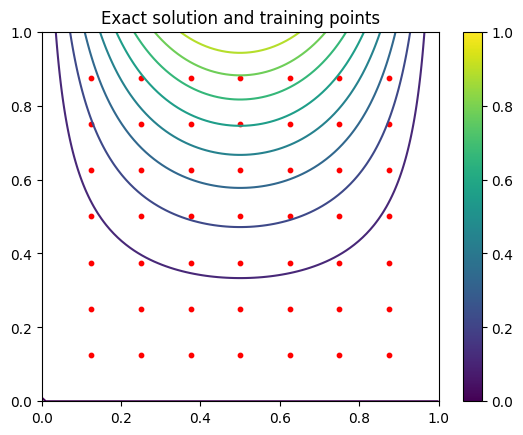

Epoch 0, loss = 3.20e-01
Epoch 200, loss = 2.57e-05
Epoch 400, loss = 1.76e-05
Epoch 600, loss = 1.11e-05
Epoch 800, loss = 6.71e-06
Epoch 1000, loss = 3.93e-06
Epoch 1200, loss = 2.27e-06
Epoch 1400, loss = 1.30e-06


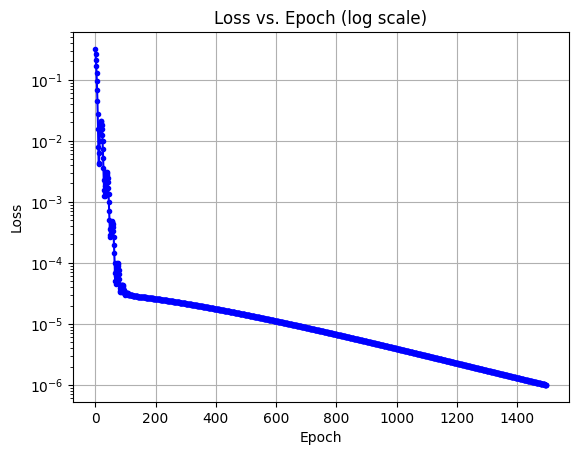

Max error: 1.975862492218511e-05


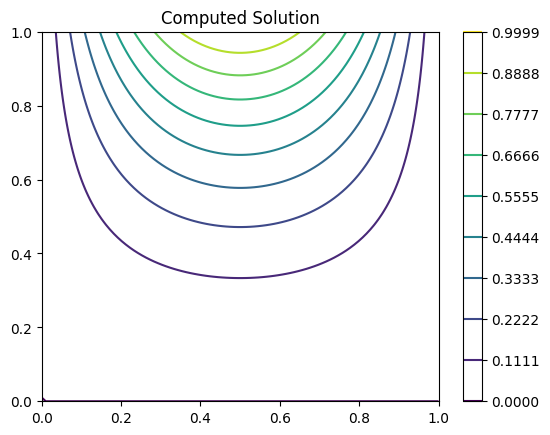

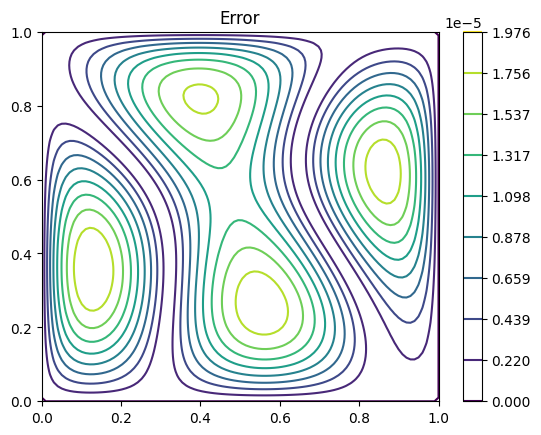

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_dtype(torch.float64)


def u_exact(x, y):
    return y.pow(2) * torch.sin(np.pi * x)

def prepare_data(nx, ny, strip):
    xs = torch.linspace(0, 1, nx)
    ys = torch.linspace(0, 1, ny)
    if strip:
        grid_x, grid_y = torch.meshgrid(xs[1:-1], ys[1:-1], indexing='ij')
    else:
        grid_x, grid_y = torch.meshgrid(xs, ys, indexing='ij')
    pts = torch.stack((grid_x.reshape(-1), grid_y.reshape(-1)), dim=1)
    return grid_x, grid_y, pts

xtr, ytr, train_pts = prepare_data(9, 9, True)
xte, yte, test_pts = prepare_data(100, 100, False)

sol_ex = u_exact(xte, yte)
plt.figure()
plt.contour(xte.numpy(), yte.numpy(), sol_ex.numpy(),
            levels=np.linspace(sol_ex.min().item(), sol_ex.max().item(), 10))
plt.scatter(train_pts[:,0].numpy(), train_pts[:,1].numpy(), s=10, c='#FF0000')
plt.colorbar()
plt.title("Exact solution and training points")
plt.show()


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)
    def forward(self, x):
        out = self.fc1(x)
        out = torch.tanh(out)
        out = self.fc2(out)
        return out

def trial(x, y, nn_out):
    A = (y.pow(2) * torch.sin(np.pi * x)).unsqueeze(1)
    B = (x * (1 - x) * y * (1 - y)).unsqueeze(1)
    return A + B * nn_out


def rhs(x, y):
    return (2 - (np.pi**2) * y.pow(2)) * torch.sin(np.pi * x)


net = Net()
train_pts.requires_grad_(True)
train_dataset = TensorDataset(train_pts)
loader = DataLoader(train_dataset, batch_size=49, shuffle=True)

mse = nn.MSELoss()
opt = optim.Adam(net.parameters(), lr=1e-2)


loss_history = []
num_epochs = 2000
tol = 1e-6

for epoch in range(num_epochs):
    for (X,) in loader:
        X.requires_grad_(True)
        nn_out = net(X)
        Q = trial(X[:,0], X[:,1], nn_out)
        grad_Q = torch.autograd.grad(Q, X, torch.ones_like(Q), create_graph=True)[0]
        Qx, Qy = grad_Q[:,0], grad_Q[:,1]
        Qxx = torch.autograd.grad(Qx, X, torch.ones_like(Qx), create_graph=True)[0][:,0]
        Qyy = torch.autograd.grad(Qy, X, torch.ones_like(Qy), create_graph=True)[0][:,1]
        res = Qxx + Qyy - rhs(X[:,0], X[:,1])
        loss = mse(res, torch.zeros_like(res))
        opt.zero_grad()
        loss.backward()
        opt.step()
    loss_history.append(loss.item())
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, loss = {loss.item():.2e}")
    if loss.item() < tol:
        break

plt.figure()
plt.semilogy(loss_history, 'b.-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch (log scale)")
plt.grid(True)
plt.show()

with torch.no_grad():
    sol_vec = trial(test_pts[:,0], test_pts[:,1], net(test_pts))
    sol_num = sol_vec.squeeze().reshape(100, 100)
err = (sol_num - u_exact(xte, yte)).abs()
print("Max error:", err.max().item())

plt.figure()
plt.contour(xte.numpy(), yte.numpy(),
            sol_num.numpy(), levels=np.linspace(sol_ex.min().item(), sol_ex.max().item(), 10))
plt.colorbar()
plt.title("Computed Solution")
plt.show()

plt.figure()
plt.contour(xte.numpy(), yte.numpy(),
            err.numpy(), levels=np.linspace(0, err.max().item(), 10))
plt.colorbar()
plt.title("Error")
plt.show()
